In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.ensemble import RandomForestRegressor

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
bikedata= pd.read_csv('daily-bike-share.csv')
bikedata

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [3]:
X = bikedata.drop(['rentals','instant', 'dteday', 'yr'], axis=1,).copy()
y = bikedata['rentals'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
num_features = ['temp', 'difference_temp', 'hum', 'windspeed']
cat_features = ['season','mnth','holiday','weekday','workingday','weathersit']

In [5]:
class TempFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['difference_temp'] = (X['atemp'] - X['temp']) / X['temp']
        X.drop('atemp', axis=1, inplace=True)
        return X

In [6]:
num_preparation = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_preparation = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

In [7]:
model_pipeline = Pipeline(steps=[
    ('temp_feature', TempFeatures()),
    ('data preparation', data_preparation),
    ('model', RandomForestRegressor(random_state=42))
])

In [8]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []


def calculate_regression_metrics(model, name, X_checked, y_checked):
    predictions = model.predict(X_checked)

    mae = mean_absolute_error(y_checked, predictions)
    rmse = np.sqrt(mean_squared_error(y_checked, predictions))
    r2 = r2_score(y_checked, predictions)

    print(f"Model: {name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2: {r2:.2f}")

    # wykres: rzeczywiste vs przewidywane
    plt.figure(figsize=(6, 6))
    plt.scatter(y_checked, predictions, alpha=0.5)
    plt.plot([y_checked.min(), y_checked.max()], [y_checked.min(), y_checked.max()], 'r--')
    plt.xlabel('Wartości rzeczywiste')
    plt.ylabel('Wartości przewidziane')
    plt.title(f'Regresja - {name}')
    plt.show()

In [9]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('temp_feature', TempFeatures()),
                ('data preparation',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'difference_temp',
                                                   'hum', 'windspeed']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])])),
                ('model', RandomForestRegressor(random_state=42))])

Model: Linear Regression
MAE: 200.09
RMSE: 288.18
R^2: 0.76


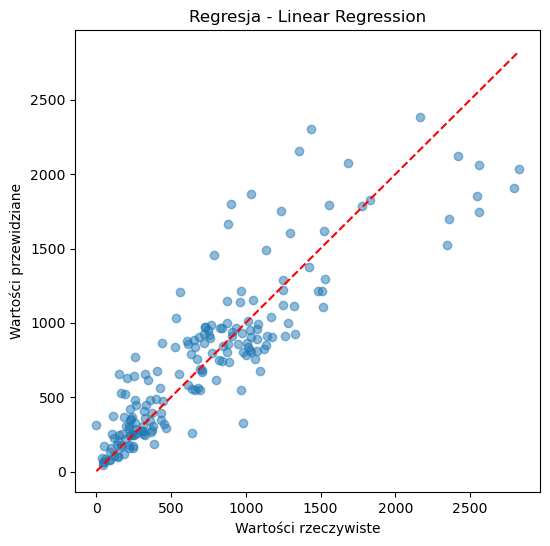

In [10]:
calculate_regression_metrics(model_pipeline, 'Linear Regression', X_test, y_test)

Model z pipeline wykazuje znaczną poprawę:
- MAE spadło z 348 do 200,
- RMSE spadło z 484 do 288,
- R² wzrosło z 0.52 do 0.76.